In [180]:
# 2018-06-11
# A. Pendleton
# Parsing the BLATs of the high scoring, non-redundant de novo genes from Zoey2.3
#    against CanFam3.1 to identify which are novel to Zoey, or already partially/fully
#    captured in the CanFam3.1 assembly
# Then, these are linked to the BLAST2GO 

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [57]:
# Final Gene directory to keep the parsed gene model information
finalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'

# Create dictionary with ALL gene models as keys

In [4]:
totalGeneFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/input/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa'

geneDict = {}
geneList = []

for line in open(totalGeneFile,'r'):
    if '>' not in line: #only want identifer
        continue
    line=line.rstrip().replace('>','')
    shortID = line.split('::')[1]
    geneDict[shortID] = []
    geneList.append(shortID)

print('%i gene models added to dictionary' % len(geneList))


24667 gene models added to dictionary


# GET ZOEY COORDINATES FOR ALL GENE MODELS

In [66]:
geneBed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/input/HighestScoringTranscripts_IDs.bed'
zoeyCoordDict = {}
newBed = open(finalDir + 'Zoey_FinalGenes.12.bed', 'w')
count = 0

for LINE in open(geneBed,'r'):
    line=LINE.rstrip().split('\t')
    shortID = line[3].split('::')[1]
    
    #We only want the genes that passed all of our subsequent filtration, so make sure each gene 
    #   is in our geneList array
    if shortID not in geneList:
        continue
    zoey_chrom, zoey_start, zoey_end, zoey_strand = line[0], line[1], line[2], line[5]
    zoeyCoordDict[shortID] = [zoey_chrom,zoey_start,zoey_end, zoey_strand]
    
    #write all of this out to bedfile
    newBed.write('%s' % LINE)
    count += 1

    
print('Added %i gene coordinates to dictionary and output file' % count)
newBed.close()    
    

Added 24667 gene coordinates to dictionary and output file


# BLAT TO CANFAM3
### Reading in the BLAT results against CanFam

In [146]:
"""#Where are all the BLAT results
#blatDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/BLAT_to_CanFam/'
blatDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/BLAT_to_CanFam/blat_results/'

count = 0 #Keeping track of how many 
blatDict = {} #To store all of the results from the BLATs

#The gene sequences were split into multiple subsets to make the BLAT faster. 
#Read each blat output file (*psl) in with a loop
#for file in glob.glob(blatDir+ 'results/' + 'cds*psl'):
for file in glob.glob(blatDir + 'cds*psl'):
    if '14500' not in file:
        continue
        
    lineCount = 0
    miss = 0
    for line in open(file,'r'):
        lineCount += 1
        #BLAT results don't start until the sixth line in PSL files, so ignore lines above line #6
        #if lineCount < 6:
        #    continue
        line=line.rstrip().split()
        hitLength, orient, chrom, start, end = int(line[0]),line[8],line[9],int(line[11]),int(line[12])
        
        #gene information
        geneID, shortgeneID = line[13], line[13].split('::')[1]
        geneLength = int(line[14])
        
        #alignment blocks
        blockLengths = line[-3].split(',')
        blockSumLength = 0
        for b in range(0,len(blockLengths)-1):
            blockSumLength = blockSumLength + int(blockLengths[b])
   
        #Calculate the proportion of the hit as the sum of the blocks that align
        propHit = float(blockSumLength)/geneLength
        #What type of hit is it? Full/Partial/No hit
        if propHit >= 0.9:
            hitType = 'Full'
        if propHit >= float(1/3) and propHit < 0.9:
            hitType = 'Partial'
        #Skip the genes that are not aligning with at least a third of their length
        if propHit < float(1/3):
            hitType = 'No hit'
            continue
        
        #Add to dictionary if not in there
        if shortgeneID not in blatDict.keys():
            blatDict[shortgeneID] = ['',propHit,chrom,start,end,geneID,orient,hitType,line]
            blatDict[shortgeneID][0] = []
            #Save first hit automatically as the best hit
            topPropHit = propHit
        
        #Keep track of all proportion of hits
        blatDict[shortgeneID][0].append(propHit)

        #Save it all to a dictionary
        if propHit > topPropHit:
            #Redefine the top hit (topPropHit) as propHit's value since it's now larger
            topPropHit = propHit
            blatDict[shortgeneID][1] = propHit
            blatDict[shortgeneID][2] = chrom
            blatDict[shortgeneID][3] = start
            blatDict[shortgeneID][4] = end
            blatDict[shortgeneID][5] = geneID
            blatDict[shortgeneID][6] = orient
            blatDict[shortgeneID][7] = hitType
            blatDict[shortgeneID][8] = line
    #break
print('Added %i genes to dictionary that at least partially hit (>1/3 of length)' % (len(blatDict.keys())))
print('Done')    """

IndexError: list index out of range

In [169]:
#Where the BLAT results located:
blatDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/BLAT_to_CanFam/blat_results/'

blatDict = {} #To store all of the results from the BLATs

#The gene sequences were split into multiple subsets to make the BLAT faster. 
#Read each blat output file (*psl) in with a loop
for file in glob.glob(blatDir + 'cds*psl'):
    for line in open(file,'r'):
        line=line.rstrip().split()
        hitLength, orient, chrom, start, end = int(line[0]),line[8],line[13],int(line[14]),int(line[15])
        
        #gene information
        geneID, shortgeneID = line[9], line[9].split('::')[1]
        geneLength = int(line[10])
        
        #alignment blocks
        blockLengths = line[-3].split(',')
        blockSumLength = 0
        for b in range(0,len(blockLengths)-1):
            blockSumLength = blockSumLength + int(blockLengths[b])
   
        #Calculate the proportion of the hit as the sum of the blocks that align
        propHit = float(blockSumLength)/geneLength
        #What type of hit is it? Full/Partial/No hit
        if propHit >= 0.9:
            hitType = 'Full'
        if propHit >= float(1/3) and propHit < 0.9:
            hitType = 'Partial'
        #Skip the genes that are not aligning with at least a third of their length
        if propHit < float(1/3):
            hitType = 'No hit'
            continue
        
        #Add to dictionary if not in there
        if shortgeneID not in blatDict.keys():
            blatDict[shortgeneID] = ['',propHit,chrom,start,end,geneID,orient,hitType,line]
            blatDict[shortgeneID][0] = []
            #Save first hit automatically as the best hit
            topPropHit = propHit
        
        #Keep track of all proportion of hits
        blatDict[shortgeneID][0].append(propHit)

        #Save it all to a dictionary
        if propHit > topPropHit:
            #Redefine the top hit (topPropHit) as propHit's value since it's now a better alignment
            topPropHit = propHit
            blatDict[shortgeneID][1] = propHit
            blatDict[shortgeneID][2] = chrom
            blatDict[shortgeneID][3] = start
            blatDict[shortgeneID][4] = end
            blatDict[shortgeneID][5] = geneID
            blatDict[shortgeneID][6] = orient
            blatDict[shortgeneID][7] = hitType
            blatDict[shortgeneID][8] = line
    #break #for testing first file
print('Added %i genes to dictionary that at least partially hit (>1/3 of length)' % (len(blatDict.keys())))
print('Done')    

Added 24572 genes to dictionary that at least partially hit (>1/3 of length)
Done


# BLAST2GO
#### Now that we have read all of the BLAT results into a dictionary. 
#### We next need to read in the BLAST2GO Data to link genes-function

In [151]:
blast2GODir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/'
b2Gofile = blast2GODir + 'Total_BLAST2GO_table.txt'
b2GoDict = {}
count = 0

for line in open(b2Gofile,'r'):
    if 'Tags' in line: #Skips header
        continue
    line=line.rstrip().split('\t')#split line by tab
    count +=1 

    #Get the gene ID
    if 'scaffold' not in line[2] and 'blat' not in line[2]:
        shortID = line[2].split('_')[1]
    if 'scaffold' in line[2] or 'blat' in line[2]:
        shortID = line[2].split('_')[1] + '_' + line[2].split('_')[2]

        
    #Column 2 details if the gene has been BLASTED/MAPPED/ANNOTATED
    #NO BLAST HIT:
    if 'NO-BLAST' in line[1]:
        status = 'No BLAST Hit'
        b2GoDict[shortID] = [status, '',int(line[4]),'','','','','','', '']
        continue
    
    #ONLY WILL HAVE INFORMATION ABOUT TOP BLAST HIT, NO ANNOTATION INFO
    hitDesc, length, hitCount, evalue, sim_mean = line[3], int(line[4]), int(line[5]), line[6], float(line[7]), 

    if 'BLASTED' in line[1] and 'MAPPED' not in line[1] and 'ANNOTATED' not in line[1]:
        status = 'BLAST only'
        GOs, GODesc = '', ''
    
    #WILL HAVE GO INFORMATION FOR THOSE CLASSIFIED AS HAVING BEEN MAPPED AND/OR ANNOTATED
    if 'BLASTED' in line[1] and 'MAPPED' in line[1] and 'ANNOTATED' not in line[1]:
        status = 'Putative'
        GOs, GODesc = line[9], line[10]
    if 'ANNOTATED' in line[1]:
        status = 'Annotated'
        GOs, GODesc = line[9], line[10]
        
    #Add the enzyme code information for lines that HAVE that information
    if 'EC:' in line:
        EC, ECDesc = line[9], line[10]
    else:
        EC, ECDesc = '', ''
    
    
    #CREATE DICTIONARY TO STORE ALL THIS
    b2GoDict[shortID] = [status, hitDesc,length,hitCount,evalue,sim_mean,GOs,GODesc,EC, ECDesc]
    
print('Added %i BLAST2GO genes into b2GoDict' % len(b2GoDict.keys()))


Added 24666 BLAST2GO genes into b2GoDict


# Kalisto
### Incorporation of expression quantification data

In [161]:
kalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Kalisto/'
resultsDir = kalDir + 'results/'

samplesProcessed = []
for files in glob.glob(resultsDir + 'SRR*'):
    samplesProcessed.append(files.replace(resultsDir,''))
    
print('%i samples processed through Kallisto' % len(samplesProcessed))

42 samples processed through Kallisto


In [166]:
#CALCULATE STATS AND DRAW PLOTS PER SAMPLE
sampleCount = 0

tpmDict = {}

for sample in samplesProcessed:
    tpms = [] #clear per sample
    sampleCount += 1
    
    inFile = resultsDir + sample + '/' + 'abundance.tsv'
    for line in open(inFile,'r'):
        if 'target_id' in line:
            continue
        line=line.rstrip().split('\t')
        shortID = line[0].split('::')[1]
        tpm = float(line[4])

        #if only the first sample, create key for the gene
        if sampleCount == 1:
            #0 = library expression TPMs, Pass/Fail CD-Hit
            tpmDict[shortID] = [[],'Fail','','','','']
        #If expressed at tpm > 1, add to dictionary
        if tpm > 1.0:
            tpmDict[shortID][0].append(tpm) #add TPM to total dictionary      
        tpms.append(tpm) #add TPM to per saple array for stats (below)
print('%i samples processed' % sampleCount)

42 samples processed


In [167]:
for gene in geneList:
    libraryCount = 0
    for i in tpmDict[gene][0]:
        if i > 1:
            libraryCount += 1
    geneDict[gene]['Kalisto_LibrariesExpression'] = libraryCount
    if libraryCount > 1:
        geneDict[gene]['Expressed_Status'] = 'Expressed'
    break

[[5.10648, 7.52636, 5.5407, 11.1552, 19.3872, 1.32424, 17.414, 226.251, 1.60572, 1.65545, 184.701, 1.29266, 11.4023, 23.9484, 1.29205, 5.11234, 1.25175, 22.8769, 7.01007, 3.96775, 2.68321, 18.6196, 21.1695, 1.35946, 20.1831, 210.09, 3.4584, 1.46049, 8.62191], 'Fail', '', '', '', '']


## Gene Names --> Gene Symbols
#### BLAST2GO  PRO output a GFF file that can be parsed to get the gene symbols

In [262]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/Total_BLAST2GO.gff'
symbolDict = {}

for line in open(gffFile,'r'):
    if '#' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    
    shortID = line[0].split('_')[1]
    
    info = line[8].split(';')
    
    symbolDict[shortID] = []
    geneSymbol = shortID #default
    
    #Dearch the GFF info line if there is a gene Symbol
    for i in range(2,len(info)):
        if 'Gene' in info[i]:
            geneSymbol = info[i].split(' ')[1].replace('"','')
            if '_' in geneSymbol: #these are mostly hypothetical proteins in the other species
                continue
            #Make all letters upper-case
            geneSymbol = geneSymbol.upper()
            
            #Eliminate those that are not specific. Will add them back if there's nothing else
            if 'LOC' in geneSymbol:
                continue
            if 'A0A' in geneSymbol: #there may be other top gene Symbols you want to look at first
                continue
            if 'DKFZ' in geneSymbol:
                continue

            if geneSymbol in symbolDict[shortID]: #Dont add if it's already in there 
                continue
            symbolDict[shortID].append(geneSymbol)
    if len(symbolDict[shortID]) == 0:
        if geneSymbol != shortID: #If there was something else from the loop above, just go with this instead of the generic gene ID
            symbolDict[shortID].append(geneSymbol) #even if it has a _ in the name
            continue
        else: #If no other symbols were available for this locus, then just name the gene the last gene Symbol given to the gene
            geneSymbol = shortID
            symbolDict[shortID].append(geneSymbol)

    #For testing:
    """if len(symbolDict.keys()) > 29:
        break"""
print('Added %i annotated genes and gene symbols to symbolDict' % len(symbolDict.keys()))




Added 24475 annotated genes and gene symbols to symbolDict


# Integrate the Mapping Data, Novelty Status (hits to CanFam), and Annotations (BLAST2GO) into one large datafile

In [263]:
geneDict = {}

for gene in geneList:
    geneDict[gene] = {}

      
    #Get Zoey coordinates for gene
    if gene in zoeyCoordDict.keys():
        geneDict[gene]['Zoey_Chrom'] = zoeyCoordDict[gene][0]
        geneDict[gene]['Zoey_Start'] = zoeyCoordDict[gene][1]
        geneDict[gene]['Zoey_End'] = zoeyCoordDict[gene][2]
        geneDict[gene]['Zoey_Strand'] = zoeyCoordDict[gene][3]
    else:
        print('ERROR CHECK: Why is this not in Zoeys dictionary?')
    
    #Get CANFAM BLAT INFORMATION
    if gene in blatDict.keys():
        geneDict[gene]['FullGeneID'] = blatDict[gene][5]
        geneDict[gene]['CanFam_AlignmentStatus'] = blatDict[gene][7]
        geneDict[gene]['CanFam_Chrom'] = blatDict[gene][2]
        geneDict[gene]['CanFam_Start'] = blatDict[gene][3]
        geneDict[gene]['CanFam_End'] = blatDict[gene][4]
        geneDict[gene]['CanFam_PropAlign'] = blatDict[gene][1]
        geneDict[gene]['CanFam_Strand'] = blatDict[gene][2]
    else:
        geneDict[gene]['FullGeneID'] = ''
        geneDict[gene]['CanFam_AlignmentStatus'] = 'No hit'
        geneDict[gene]['CanFam_Chrom'] = ''
        geneDict[gene]['CanFam_Start'] = ''
        geneDict[gene]['CanFam_End'] = ''
        geneDict[gene]['CanFam_PropAlign'] = ''
        geneDict[gene]['CanFam_Strand'] = ''      
    
    #Get Annotation information, if available
    if gene in b2GoDict.keys():
        #b2GoDict[shortID] = [status, hitDesc,length,hitCount,evalue,sim_mean,GOs,GODesc,EC, ECDesc]
        geneDict[gene]['B2GO_Status'] = b2GoDict[gene][0]
        geneDict[gene]['B2GO_TopHitDesc'] = b2GoDict[gene][1]
        geneDict[gene]['GeneLength'] = b2GoDict[gene][2]
        geneDict[gene]['B2GO_HitCount'] = b2GoDict[gene][3]
        geneDict[gene]['B2GO_HitEvalue'] = b2GoDict[gene][4]
        geneDict[gene]['B2GO_MeanHitSimilarity'] = b2GoDict[gene][5]
        geneDict[gene]['B2GO_GOs'] = b2GoDict[gene][6]
        geneDict[gene]['B2GO_GOsDesc'] = b2GoDict[gene][7]
        geneDict[gene]['B2GO_EnzymeCode'] = b2GoDict[gene][8]
        geneDict[gene]['B2GO_EnzymeCodeDesc'] = b2GoDict[gene][9]
    else:
        geneDict[gene]['B2GO_Status'] = ''
        geneDict[gene]['B2GO_TopHitDesc'] = ''
        geneDict[gene]['GeneLength'] = ''
        geneDict[gene]['B2GO_HitCount'] = ''
        geneDict[gene]['B2GO_HitEvalue'] = ''
        geneDict[gene]['B2GO_MeanHitSimilarity'] = ''
        geneDict[gene]['B2GO_GOs'] = ''
        geneDict[gene]['B2GO_GOsDesc'] = ''
        geneDict[gene]['B2GO_EnzymeCode'] = ''
        geneDict[gene]['B2GO_EnzymeCodeDesc'] = ''        

    #EXPRESSION DATA = KALISTO
    libraryCount = 0
    for i in tpmDict[gene][0]:
        if i > 1:
            libraryCount += 1
    geneDict[gene]['Kalisto_LibrariesExpression'] = libraryCount
    if libraryCount > 1:
        geneDict[gene]['Kalisto_ExpressionStatus'] = 'Expressed'
    else:
        geneDict[gene]['Kalisto_ExpressionStatus'] = 'Not Expressed'
    
    #GENE SYMBOLS = BLAST2GO GFF OUTPUT FILE
    if gene in symbolDict.keys():
        geneDict[gene]['B2GO_GeneSymbol'] = ', '.join(symbolDict[gene])
    else:
        geneDict[gene]['B2GO_GeneSymbol'] = gene

        
print('Added %i genes to the final, total dictionary (geneDict) ' % len(geneDict.keys()))
    


Added 24667 genes to the final, total dictionary (geneDict) 


#### Write the dictionary to an outfile with header line

In [264]:
dataOrder = ['Zoey_Chrom','Zoey_Start','Zoey_End','Zoey_Strand','GeneLength',
            'CanFam_AlignmentStatus','CanFam_Chrom','CanFam_Start','CanFam_End','CanFam_Strand','CanFam_PropAlign',
            'B2GO_Status','B2GO_GeneSymbol','B2GO_TopHitDesc','B2GO_HitCount','B2GO_HitEvalue','B2GO_MeanHitSimilarity',
            'B2GO_GOs','B2GO_GOsDesc','B2GO_EnzymeCode','B2GO_EnzymeCodeDesc',
             'Kalisto_ExpressionStatus','Kalisto_LibrariesExpression']

#OUTFILE:
geneOutfile = open(finalDir + 'FinalDeNovoGenes_ZoeyCoord_CanfamCoord_BLAST2GO.txt','w')

#What are the headers for each column? Use array above
headerLine = []
headerLine.append('ShortGeneID')
for dataColumn in dataOrder:
    headerLine.append(dataColumn)
geneOutfile.write('\t'.join(headerLine) + '\n')
    
for gene in geneDict.keys():
    data = []
    data.append(gene)
    for dataColumn in dataOrder:
        data.append(str(geneDict[gene][dataColumn]))
    geneOutfile.write('\t'.join(data) + '\n')
    
geneOutfile.close()

In [100]:
################################################################################################
################################################################################################

# Descriptive Stats

pleckstrin homology-like domain family A member 3 chr7 1432189 1435670
inositol polyphosphate multikinase isoform X2 chr4 10641132 10701629
N-myc proto-oncogene protein chr17 11707594 11709897
NF-kappa-B inhibitor epsilon chr12 12677108 12680230
Krueppel-like factor 13 chr3 37539800 37590825
twist-related protein 1 chr14 33412636 33414301
E3 ubiquitin-protein ligase RNF149 chr10 42202755 42228971
olfactory receptor 51F2-like chr21 27107585 27112328
transmembrane protein 186 chr6 33376147 33378245
pleckstrin homology domain-containing family M member 1 chr9 10913426 10960713
transcriptional repressor scratch 1 chr13 37929168 37933153
tail-anchored protein insertion receptor WRB isoform X2 chr31 33528128 33538722
peroxisomal N(1)-acetyl-spermine/spermidine oxidase chr28 41076531 41087693
transcription factor HES-1 chr23 52667361 52670001
serine/threonine-protein kinase LMTK3 chr1 107962668 107982004
amino-terminal enhancer of split isoform X1 chr20 55903906 55912933
calcineurin B homolog

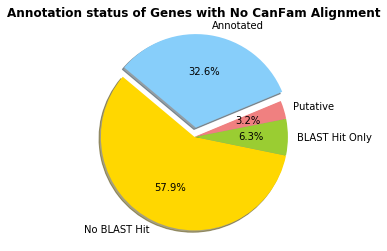

In [160]:
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if 'No hit' in geneDict[gene]['CanFam_AlignmentStatus']:
        if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
            NoB2GO += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'BLAST only':
            BlastOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Putative':
            MappedOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Annotated':
            Annotated += 1
            print(geneDict[gene]['B2GO_TopHitDesc'],geneDict[gene]['Zoey_Chrom'],geneDict[gene]['Zoey_Start'],geneDict[gene]['Zoey_End'])
            continue
        else:
            print('ERROR: What else is there?')
            print(gene,geneDict[gene])
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
            
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of Genes with No CanFam Alignment', fontweight='bold') 
plt.axis('equal')
plt.show()